In [27]:
path='H:/Datatsets/Highlights generations/'
filename='IMVBRC.wav'
import librosa
x, sr = librosa.load(path+filename,sr=16000)



We can get the duration of the audio clip in minutes using the code below:


In [28]:
int(librosa.get_duration(x, sr)/60)

9

Now, we will break the audio into chunks of 5 seconds each since we are interested in finding out whether a particular audio chunk contains a rise in the audio voice:

In [29]:
max_slice=5
window_length = max_slice * sr



Let us listen to one of the audio chunks:


In [30]:
import IPython.display as ipd
a=x[21*window_length:22*window_length]
ipd.Audio(a, rate=sr)



Compute the energy for the chunk:


In [31]:
energy = sum(abs(a**2))
print(energy)

316.19677983518227


In [32]:
len(a)

80000



Visualize the chunk in the time-series domain:


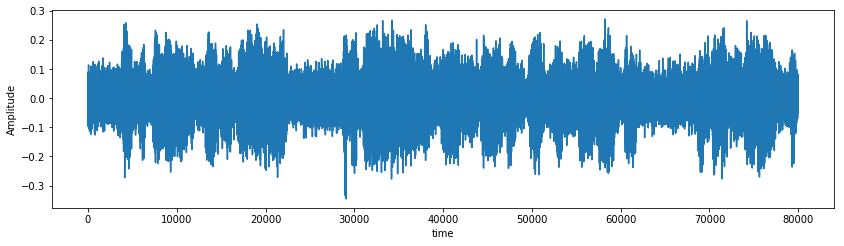

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(a)



As we can see, the amplitude of a signal is varying with respect to time. Next, compute the Short Time Energy for every chunk:


In [34]:
import numpy as np
energy = np.array([sum(abs(x[i:i+window_length]**2)) for i in range(0, len(x), window_length)])

In [35]:
energy

array([ 1330.7156628 ,  2214.92138383,   476.20699976,   229.64583767,
         211.34978714,   236.56402744,   151.38051531,   143.64196014,
         155.62871729,   149.29279367,   165.83567822,   174.01216887,
         289.71357864,   362.42294356,   440.21616381,   225.8577896 ,
         326.75576345,   372.15848824,   328.89905287,   551.45460702,
         396.22967008,   316.19677984,   227.79074548,   222.51175284,
         190.00567957,   336.91464014,    38.32568124,    57.41977547,
         577.86688576,   487.6042687 ,   364.39427198,   684.42126707,
         488.02876871,   344.88057586,   338.71590419,   344.2152986 ,
         313.07416149,   326.74607402,   192.75919315,   296.70474364,
         137.85210168,   298.95236228,   337.07884662,   351.78842115,
         400.80624935,   798.35239151,   648.69338129,   574.4829052 ,
         485.43947003,   426.74798071,   320.28003145,   475.82582065,
         264.80594031,   220.79905482,   449.87111445,   771.55937632,
      



Let us understand the Short Time Energy distribution of the chunks:


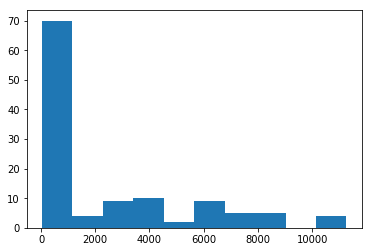

In [36]:
import matplotlib.pyplot as plt
plt.hist(energy)
plt.show()



The energy distribution is right-skewed as we can see in the above plot. We will choose the extreme value as the threshold since we are interested in the clips only when the commentator’s speech and spectators cheers are high.

Here, I am considering the threshold to be 12,000 as it lies on the tail of the distribution. Feel free to experiment with different values and see what result you get.


In [37]:
import pandas as pd
df=pd.DataFrame(columns=['energy','start','end'])

In [38]:
thresh=2000
row_index=0
for i in range(len(energy)):
    value=energy[i]
    if(value>=thresh):
        i=np.where(energy == value)[0]
        df.loc[row_index,'energy']=value
        df.loc[row_index,'start']=i[0] * 5
        df.loc[row_index,'end']=(i[0]+1) * 5
        row_index= row_index + 1

In [39]:
df

,energy,start,end
0,2214.92,5,10
1,3388.72,355,360
2,2788.72,360,365
3,3933.66,365,370
4,2464.87,370,375
5,2947.7,375,380
6,3067.16,380,385
7,3494.83,390,395
8,5336.76,395,400
9,2336.33,400,405


Merge consecutive time intervals of audio clips into one:

In [40]:
temp=[]
i=0
j=0
n=len(df) - 2
m=len(df) - 1
while(i<=n):
    j=i+1
    while(j<=m):
        if(df['end'][i] == df['start'][j]):
            df.loc[i,'end'] = df.loc[j,'end']
            temp.append(j)
            j=j+1
        else:
            i=j
            break

In [41]:
df.drop(temp,axis=0,inplace=True)

In [42]:
df

,energy,start,end
0,2214.92,5,10
1,3388.72,355,385
7,3494.83,390,480
25,8501.46,485,555
39,8885.23,560,590




Extract the video within a particular time interval to form highlights. Remember – Since the commentator’s speech and spectators’ cheers increase only after the batsman has played a shot, I am considering only five seconds post every excitement clip:


In [43]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
start=np.array(df['start'])
end=np.array(df['end'])
for i in range(len(df)):
    if(i!=0):
        start_lim = start[i] - 5
    else:
        start_lim = start[i] 
    end_lim   = end[i]   
    filename="H:/Datatsets/Highlights generations/IMVBRC/" + str(i+1) + ".mp4"
    ffmpeg_extract_subclip(path+"IMVBRC.mp4",start_lim,end_lim,targetname=filename)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [25]:
# !pip install moviepy

In [44]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("H:/Datatsets/Highlights generations/IMVBRC/1.mp4")
clip2 = VideoFileClip("H:/Datatsets/Highlights generations/IMVBRC/2.mp4")
clip3 = VideoFileClip("H:/Datatsets/Highlights generations/IMVBRC/3.mp4")
clip4 = VideoFileClip("H:/Datatsets/Highlights generations/IMVBRC/4.mp4")
clip5 = VideoFileClip("H:/Datatsets/Highlights generations/IMVBRC/5.mp4")
# clip6 = VideoFileClip("H:/Datatsets/Highlights generations/6.mp4")
# clip7 = VideoFileClip("H:/Datatsets/Highlights generations/7.mp4")
# clip8 = VideoFileClip("H:/Datatsets/Highlights generations/8.mp4")
# clip9 = VideoFileClip("H:/Datatsets/Highlights generations/9.mp4")
# clip10 = VideoFileClip("H:/Datatsets/Highlights generations/10.mp4")
# clip11 = VideoFileClip("H:/Datatsets/Highlights generations/11.mp4")
final_clip = concatenate_videoclips([clip1,clip2,clip3,clip4,clip5])
# ,clip6,clip7,clip8,clip9,clip10,clip11
final_clip.write_videofile("H:/Datatsets/Highlights generations/IMVBRC/my_concatenation.mp4")

Moviepy - Building video H:/Datatsets/Highlights generations/IMVBRC/my_concatenation.mp4.
MoviePy - Writing audio in %s


MoviePy - Done.
Moviepy - Writing video H:/Datatsets/Highlights generations/IMVBRC/my_concatenation.mp4



Moviepy - Done !
Moviepy - video ready H:/Datatsets/Highlights generations/IMVBRC/my_concatenation.mp4
